##Neural Style Transfer

Use a pre-trained `VGG19` model as the feature extractor for a neural style transfger model

##Imports 

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt 
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

##Utilities

These will be used in loading, visualizing, and preprocessing the images 

Converts tensor to an image:

In [2]:
def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)

  number_elem_shape = tf.shape(tensor_shape)

  if  number_elem_shape > 3: 
    assert tensor_shape[0] == 1
    tensor = tensor[0]

  return tf.keras.preprocessing.image.array_to_img(tensor)

Loads an image as a tensor and sclaes it to 512 pixels:

In [3]:
def load_img(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

Loads the content and path images as tensors:

In [4]:
def load_images(content_path, style_path):
  content_image = load_img('{}'.format(content_path))
  style_image = load_img('{}'.format(style_path))

  return content_image, style_image

Displays an image with corresponding title:

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Display a row of images with corresponding title:

In [6]:
def show_images_with_objects(images, titles=[]):
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)

Displays the generated images as an animated gif

In [7]:
def display_gif(gif_path):
  with open(gif_path, 'rb') as f:
    display_fn(Image(data=f.read(), format='png'))

In [8]:
def create_gif(gid_path, images):
  mimsave(gif_path, images, fps=1)

  return gif_path

Clips the image pixel values by the given min and max:

In [9]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  return tf.clip_by_value(image, clip_value_min = min_value,
                          clip_value_max = max_value)

Centers the pixel values of a given image to use with VGG-19

In [10]:
def preprocess_image(image):
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image

##Download Images

Download a few images and choose which will be the content and which will be the style image

In [11]:
IMAGE_DIR = 'images'

# create directory
!mkdir {IMAGE_DIR}

# download images to the directory you just created
!wget -q -O ./images/cafe.jpg https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q -O ./images/swan.jpg https://cdn.pixabay.com/photo/2017/02/28/23/00/swan-2107052_1280.jpg
!wget -q -O ./images/tnj.jpg https://i.dawn.com/large/2019/10/5db6a03a4c7e3.jpg
!wget -q -O ./images/rudolph.jpg https://cdn.pixabay.com/photo/2015/09/22/12/21/rudolph-951494_1280.jpg
!wget -q -O ./images/dynamite.jpg https://cdn.pixabay.com/photo/2015/10/13/02/59/animals-985500_1280.jpg
!wget -q -O ./images/painting.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

print("image files you can choose from: ")
!ls images

image files you can choose from: 
cafe.jpg  dynamite.jpg	painting.jpg  rudolph.jpg  swan.jpg  tnj.jpg


In [12]:
#Set default images 
content_path = f'{IMAGE_DIR}/swan.jpg'
style_path = f'{IMAGE_DIR}/painting.jpg'

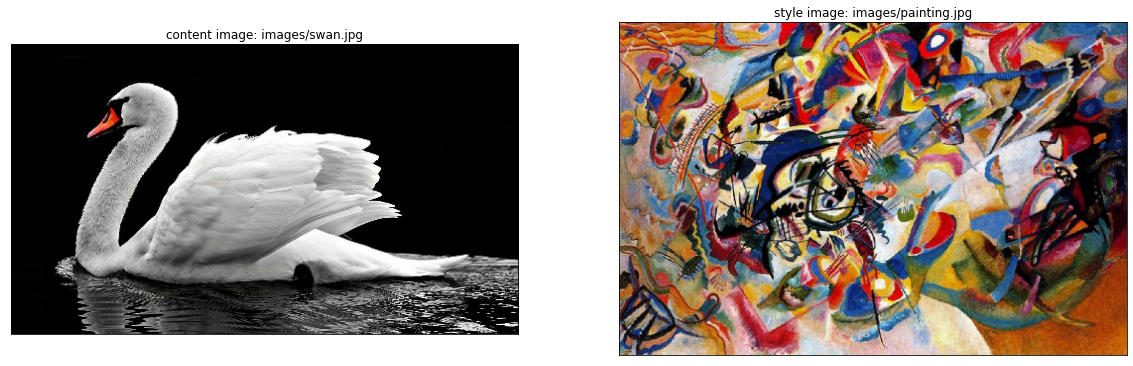

In [13]:
#Display the content and  style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],
                         titles = [f'content image: {content_path}',
                                   f'style image: {style_path}'])

##Build the Model 
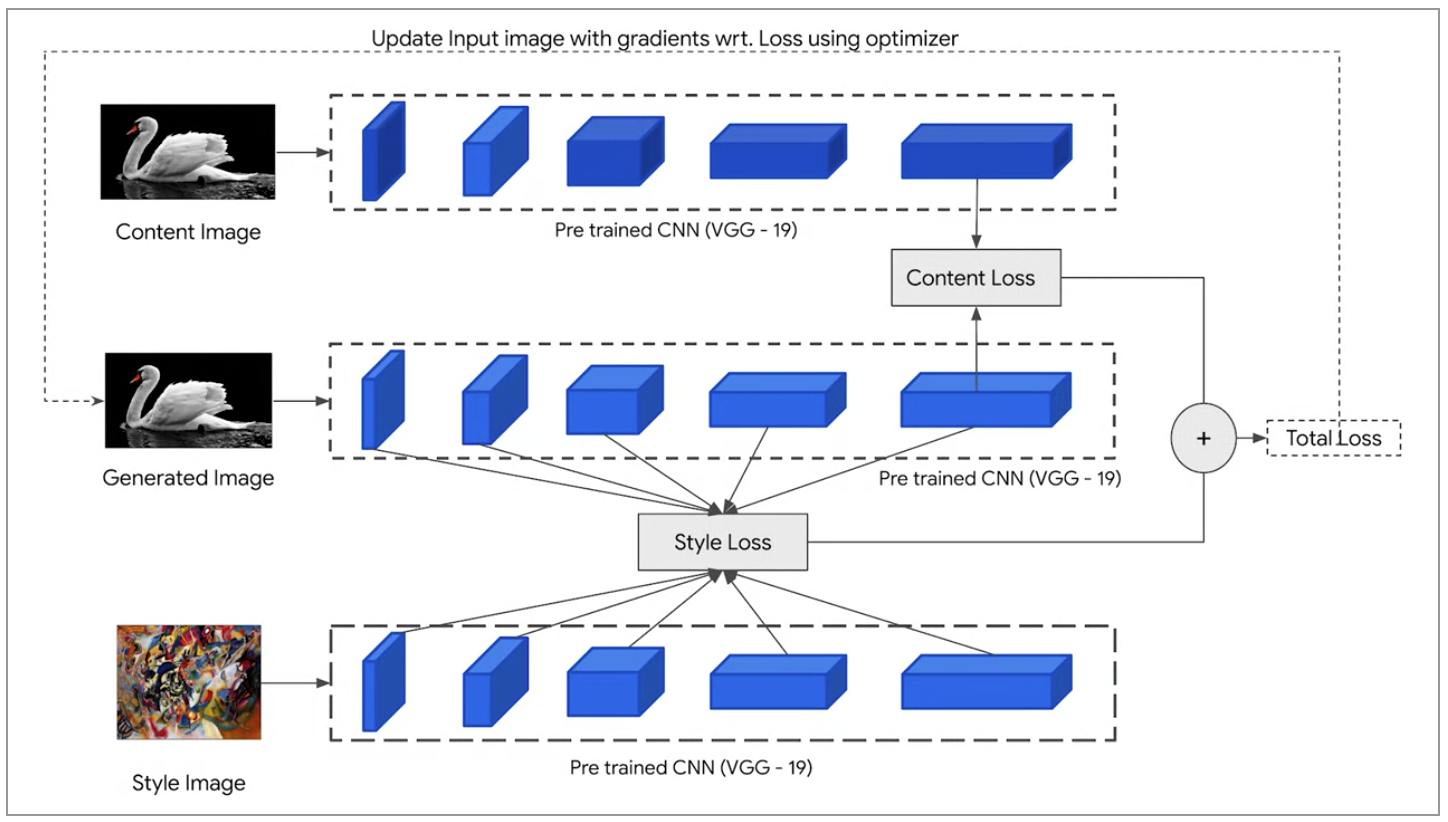

Use the VGG-19 model as the feature extractor 
* Feed in the style and content image and depending on the computed losses, a new image will be generated which has elements of both the content and style image

In [14]:
#Clear the session to make Layer naming consistent when re-running this cell 
K.clear_session()

#Download the vgg19 model and inspect the Layers 
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

del tmp_vgg

574726144/574710816 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Choose the intermediate layers for the network to extract the style and content of the image 
* For the style layers, use the first layer of each convolution block 
* For the content layer, use the second convolutional layer of the last convolutional block (just one layer)

In [15]:
#Style layers of interes 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

#Choose the content layer and put it in a list 
content_layers = ['block5_conv2']

#Combine the two list (put the style layers before the content layers)
output_layers = style_layers + content_layers

#Declare auxilary variables holding the number of style and content Layers 
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

Define the model to take the same input as the standard VGG-19 model and output the selected content and style layers 

In [16]:
def vgg_model(layer_names):
  """
  Creates a VGG model that outputs the style and content layer activations for the loss functions 

  Args:
    layer_names (list of strings): represents the names of the desired content and style layers 

  Returns:
    A model that takes the regular VGG-19 input and outputs the content and style layers 
  """

  #Load the pre-trained VGG that's trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  #Freeze the weight of the model's layers
  vgg.trainable = False

  #Create a list of layer objects that are specified by Layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  #Create the model that outputs content and style layers only 
  model = tf.keras.Model(inputs = vgg.input,
                         outputs = outputs)
  
  return model 

Create an instance of the model using the function that was just defined 

In [17]:
#Clear session to make layer naming consistent if re-runing the cell 
K.clear_session()

#Create a VGG-19 model 
vgg = vgg_model(output_layers)
vgg.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

##Define the loss functions 
Define funcitons to compute the losses required for generating the new image
* Style loss
* Content loss
* Total loss (combination of style and content losses)

#Calculate the Style Loss
The style loss is the average of the squared differences between the features and the targets 

In [18]:
def get_style_loss(features, targets):
  """
  Expects two images of dimencion (h, w, channels)

  Args:
    features: tensor with shape (h, w, channels)
    targets: tensor with shape (h, w, channels)

  Returns:
    style_loss (scalar)  
  """

  #Get the average of the squared errors 
  style_loss = tf.reduce_mean(tf.square(features - targets))
  
  return style_loss

##Calculate the Content Loss
This is the sum of the squared error between the features and targets, which is then multiplied by a scaling factor (0.5)

In [19]:
def get_content_loss(features, targets):
  """
  Expects two images of dimencion (h, w, channels)

  Args:
    features: tensor with shape (h, w, channels)
    targets: tensor with shape (h, w, channels)

  Returns:
    content_loss (scalar)  
  """

  #Get the sum of the squared error multiplied by a scaling factor 
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

#Calculate the gram matrix

USe `tf.linalg.einsum` to calculate the gram matrix for an input tensor 
* In addition, calculate the sclaing factor `num_locations` and divide the gram matrix calculation by `num_locations`
 * `num_locations` = `height` x `width`

In [32]:

def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations

  Args:
    input_tensor: tensor of shape (batch, height, width, channels)

  Returns:
    scaled_gram: gram matrix devided by the number of locations
  """
  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # get the number of locations (height times width), and cast it as tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix bu dividing by the number of locations
  scaled_gram = gram / num_locations

  return scaled_gram

#Get the style image features 
Given the style image as input, get the style features of the custom VGG model using `vgg_model()`
* `pre-process the image using the given `pre-process` image function 
* Get the outputs of the VGG model 
* From the outputs, get the style feature layers and not the content feature layer 

In [21]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

For each layer, calculate the gram matrix and store the results in list 

In [31]:
def get_style_image_features(image):
  """ Get the style image features

  Args:
    image: an input image

  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocessed the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image)

  # get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

##Get the content image features 
Follow a similar process with the get_style_image_features() but don't calculate the gram matrix with these features 

In [23]:
def get_content_image_features(image):
  """
  Get the content image features 

  Args:
    image: input image
  
  Returns:
    content_output: the content features of the image 
  """
  
  #Preprocessed the image using the given preprocessing function 
  preprocessed_content_image = preprocess_image(image)

  #Get the outputs from the VGG model
  outputs = vgg(preprocessed_content_image)

  #Get the content layers of the outputs 
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  #Return the content layer outputs of the content image 
  return content_outputs

##Calculate and style the content loss 

The total loss is given by `Total_Loss = beta * Style_Loss + alpha * Content_Loss` where beta and alpha are weights 

In [24]:
def get_style_and_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):
  """
  Combine the style and content loss

  Args:
    style_targets: style features of the style image 
    style_outputs: style features of the generated image 

    content_targets: content features of the content image 
    content_outputs: content features of the generated image 

    style_weight: weight given to the style loss 
    content_weight: weight given to the content loss

  Returns:
    total_loss: the conmbined style and content loss
  """

  #Sum of the style losses 
  style_loss = tf.add_n([ get_style_loss(style_outputs, style_targets) for style_outputs, style_targets in zip(style_outputs, style_targets) ])

  # sum of the content losses
  content_loss = tf.add_n([ get_content_loss(content_outputs, content_targets) for content_outputs, content_target in zip(content_outputs, content_targets) ])

  #Scale the style loss by multiplying by the the style weights and dividing by the nuymber of style layers 
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS

  #Scale the content loss by multiplying the content weight and dividing by the number of content layers 
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  #Sum up the style and content_loss
  total_loss = style_loss + content_loss

  return total_loss

##Generate the stylized image 

Define helper funcitons to generate the new image given the total loss

#Calculate Gradients 
First is the funciton to calculate the gradients. The values will be used to update the generated image to have more of the style and content features 

In [36]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight givent to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the inpupt image
  """
  with tf.GradientTape() as tape:
    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss = get_style_and_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)
    
  # calculate the gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

##Update the image with the style
Similar to model training, use an optimizer to update the original image from the computed gradients. Since the data is in the form of images, clip the values to the range that is expected `[0, 255]`

In [38]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """
  # calculate gradients using the function that you just defined
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight, var_weight)
  
  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # clip the image using the utility clip_image_values function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

##Style Transfer
Define the main loop that will use the previous functions that were just defined to generate the stylized content image
* It does so incrementally based on the computed gradients and the number of epochs 

In [27]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """
  Performs neural style transfer

  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  #get the style image features 
  style_targets = get_style_image_features(style_image)

  #get the content image features 
  content_targets = get_content_image_features(content_image)

  #Initialize the generated image for updates 
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  #Collect the image updates starting from the content image
  images.append(generated_image)

  #Incrementally update the content image with the style features 
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      #update the image with the style using the funciton that you defined 
      update_image_with_style(generated_image, style_targets, content_targets, style_weight, var_weight, content_weight, optimizer)

      print('.', end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)

    #display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    #Append to the image collection for visualization later 
    images.append(generated_image)
    print('Train step: {}'.format(step))

  #Convert to uint8 (expected dtype for image with pixels in the range of [0, 255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

#Test 

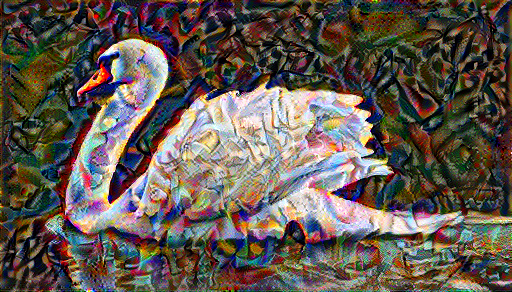

Train step: 1000


In [39]:
#Define style and content weight 
style_weight = 2e-2
content_weight = 1e-2

#Define optimizer. Learning rate decreases per epoch
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=.5
    )
)

#start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)

In [42]:
def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path

In [43]:
# display GIF of Intermedite Outputs
GIF_PATH = 'style_transfer.gif'
gif_images = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images]
gif_path = create_gif(GIF_PATH, gif_images)
display_gif(gif_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
##Add a smoothing 

In [46]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image

  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight givent to the content loss
    var_weight: weight givent to the total variation loss

  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss = get_style_and_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight)
    
    # add the total variation loss
    loss += var_weight * tf.image.total_variation(image)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients

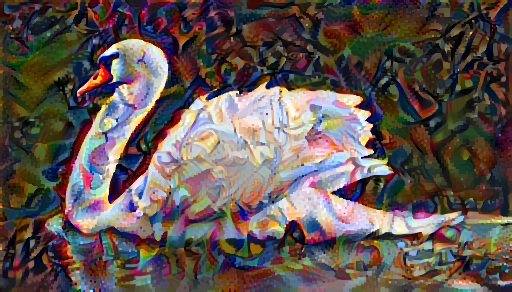

Train step: 600
........................................

KeyboardInterrupt: ignored

In [47]:
style_weight =  2e-2
content_weight = 1e-2
var_weight = 2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

stylized_image_reg, display_images_reg = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=var_weight, optimizer=adam, epochs=10, steps_per_epoch=100)